<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 🚙 05 - Visual control

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/pic1_rect.png", width=400px>
  <figcaption>The view from a Duckiebot when centered in its lane.</figcaption>
  </div>
</figure>

Now, we will combine the image processing tools that we have explored with the earlier exercise on image-based reactive control to design a policy for lane-following. Consider above image taken from the Duckiebot's camera when the Duckiebot was roughly centered in its lane. Our goal is to design a control policy that uses only images streamed from the Duckiebot's camera to keep it in the lane as it drives forward at a fixed velocity. 

Rather than design a controller that reasons over the raw image, we will process the image to enhance aspects of the image that are helpful for lane-following. The dashed-yellow and solid-white lane markings provide valuable cues for determining the robot's pose relative to the lane. When the lane is straight, if we were able to detect the dashed-yellow centerline and the solid-white line to the right, we could use their orientations in the image to control the velocities of the left and right wheels. 

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/lane-markings-angles.png", width=400px>
  <figcaption>The orientations of the edges associated with the dashed-yellow and solid-white lane markings may be useful for control.</figcaption>
  </div>
</figure>

For example, assume that we know the nominal angles of the left (dashed-yellow) and right (solid-white) lane markings, $\theta_l^d$ and $\theta_r^d$, respectively, when the vehicle is traveling straight down the middle of the lane. With the motors turning to maintain a baseline forward speed, we can vary the rotational velocities of the left and right wheels according to any deviations from from these nominal angles. 

Of course, this requires that we can detect the dashed-yellow and solid-white lane markings and estimate their orientations. Thus, we want to apply a filter that makes the lane markings "pop out" in the image, while supressing as much of distracting content of the image. As we discussed in lecture, lane markings are brightly colored against a dark background (the road). 

We can identify the location of lane markings in the image by applying finite-difference filters $h_x$ and $h_y$ (e.g., using the Sobel operator) to estimate the horizontal and vertical intensity gradients

$$ \nabla I[u,v] = 
\begin{bmatrix}
G_x[u,v]\\
G_y[u,v]
\end{bmatrix}
$$

where

$$ 
\begin{align}
G_x = h_x * I\\
G_y = h_y * I
\end{align}
$$

We can then look for regions of the image where the magnitude of the intensity gradient is large as a measure of the strength of each edge.

$$ 
\lvert \nabla I[u,v] \rvert = \sqrt{\left(G_x[u,v]\right)^2 + \left(G_y[u,v]\right)^2}
$$

Assuming that these edges correspond to the lane boundaries, the direction of the gradients can then be used to estimate the desired orientations.

$$
\theta[u,v] = \textrm{atan2}\left(G_y[u,v], G_x[u,v]\right)
$$

In this exercise, we will develop this idea by investigating different ways of processing the images to tease out information about the robot's pose relative to the lane. We will use these results to implement a reactive image-space controller that we will validate on a simulated and/or real DuckieBot.

In [196]:
## Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


Let's load the image into Python and then take a look at the horizontal and vertical gradients computed via the Sobel operator

In [220]:
# Load in the image and generate hsv and grayscale versions
#imgbgr = cv2.imread('../images/visual_control/pic1_rect.png')
#imgbgr = cv2.imread('../images/visual_control/pic11.png')
imgbgr = cv2.imread('../images/visual_control/turn.png')

# OpenCV uses BGR by default, whereas matplotlib uses RGB, so we generate an RGB version for the sake of visualization
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for any color-based filtering
imghsv = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HSV)

# Most of our operations will be performed on the grayscale version
img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

# The image-to-ground homography associated with this image (Jacopo's)
H = np.array([-4.137917960301845e-05, -0.00011445854191468058, -0.1595567007347241, 
              0.0008382870319844166, -4.141689222457687e-05, -0.2518201638170328, 
              -0.00023561657746150284, -0.005370140574116084, 0.9999999999999999])

H = np.reshape(H,(3, 3))
Hinv = np.linalg.inv(H)

## Finding the Horizon

In Duckietown, the ground is planar and in other self-driving and robotics domains, it is often assumed that the ground is locally planar. We can exploit this as we search for lane markings by not searching above the horizon. In the world frame relative to which we estimated the homography (i.e., a reference frame with the origin centered between the drive wheels with the positive $x$-axis pointing forward and the positive $y$-axis to the left), the horizon corresponds to large $x$-coordinates. In Duckietown, we are only interested in the road a few meters in front of the Duckiebot.

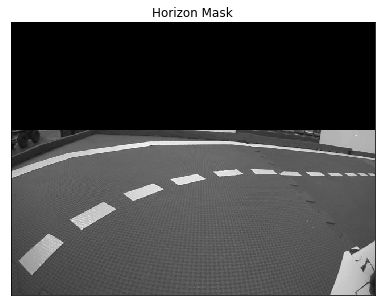

In [221]:
xmax = 2
X = np.array([xmax, 0.0, 1.0])
x = Hinv.dot(X)
x = x/x[-1]

height = img.shape[1]
mask_ground = np.ones(img.shape, dtype=np.uint8)
mask_ground[0:int(np.floor(x[1])),:] = 0

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img*mask_ground,cmap = 'gray')
ax1.set_title('Horizon Mask'), ax1.set_xticks([]), ax1.set_yticks([]);

## Detecting Lane Markings using the Canny Edge Detector

Like other edge detectors, the Canny edge detector looks for regions of the image with strong intensity gradients. Thus, it may be helpful to blur the image slightly using a Gaussian kernel in order to reduce spurious edges.

### Example: Canny Edge Detection

Using your experience from the previous exercise, identify a setting for the standard deviation of the Gaussian kernel that removes noise and local texture (e.g., that of the road surface), without sacrificing too much valid content (namely, the edges associated with lane markings)

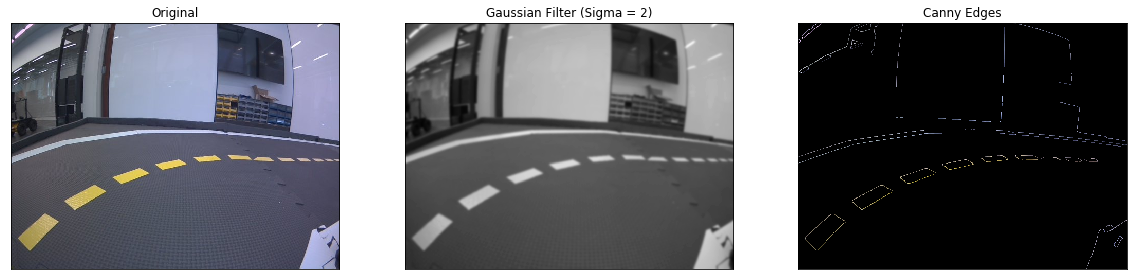

In [222]:
# TODO: Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 2

# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

canny_lower_threshold = 80
canny_upper_threshold = 200
canny_kernel_size = 3;

edges = cv2.Canny(img_gaussian_filter, canny_lower_threshold, canny_upper_threshold, canny_kernel_size)
#edges = cv2.bitwise_and(edges, edges, mask = mask_ground)
mask_edges = (edges != 0)
dst = imgbgr * (mask_edges[:,:,None].astype(imgbgr.dtype))

# Visualize the result of Canny edge detection
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax3.set_title('Canny Edges'), ax3.set_xticks([]), ax3.set_yticks([]);

## Color-based Masking

Having identified a candidate set of edges, we can now try design a set of masks that isolate the edges associated with the dashed-yellow and solid-white lane markings.

Perhaps the most obvious thing to do is to create masks that filter out pixels whose color differs from that of the yellow and white lines. 

### Exercise: Color-based Masking

Following what we did in the Braitenberg exercise, we can select upper- and lower-bounds on the HSV values for the two lines. One option mentioned in the Braitenberg exercise is to use [this online color picker](https://pinetools.com/image-color-picker), which allows us to get the HSV values for particular pixels. 

**Note**: When we go to use these bounds, remember that OpenCV uses uses the convention that $\textrm{H} \in [0, 179]$, $\textrm{S} \in [0, 255]$, and $\textrm{V} \in [0, 255]$, while other tools may use different ranges (e.g., Gimp uses $\textrm{H} \in [0, 360]$, $\textrm{S} \in [0, 100]$, and $\textrm{V} \in [0, 100])$.

**Note**: While the HSV color space provides a better representation (e.g., compared to RGB) for color-based detection, the appearance of the yellow and white lane markings will change due to variations in illumination, shading, etc. for In order to improve the generalizability of these bounds, you are encouraged to also consider the `../images/visual_control/pic3_rect.png` image and define bounds that are appropriate for both.

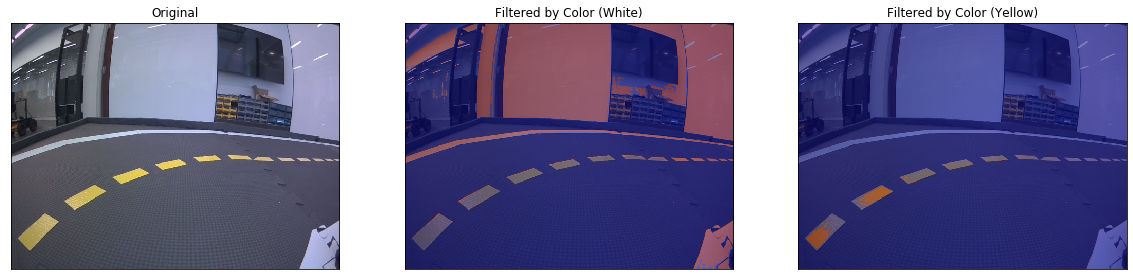

In [223]:
# Using the above tool, we can identify the bounds as follows
# Since OpenCV uses a Hue range of [0, 179], we need to divide the Hue values above by 2
white_lower_hsv = np.array([0/2, 3*255/100, 52*255/100])
white_upper_hsv = np.array([360/2, 26*255/100, 96*255/100])
yellow_lower_hsv = np.array([44/2, 47*255/100, 48*255/100])
yellow_upper_hsv = np.array([55/2, 100*255/100, 85*255/100])

mask_white_orig = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
mask_yellow_orig = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(imgrgb)
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_white_orig, cmap='jet', alpha=0.5)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(imgrgb)
ax3.imshow(mask_yellow_orig, cmap='jet', alpha=0.5)
ax3.set_title('Filtered by Color (Yellow)'), ax3.set_xticks([]), ax3.set_yticks([]);

### Exercise: Image dilation

Conservative values for the lower- and upper-bounds used for HSV filtering, will result in many false negatives (i.e., missing pixels that actually correspond to the dashed-yellow or solid-white lane markings, but that fall outside the bounds). Increasing the range will capture many of these pixels, but at the expense of false positives.

One way to deal with this is to use more conservative values for the lower- and upper-bounds, but to then grow the resulting masks to capture nearby pixels that were not detected. We can do this through image *dilation*, a morphological process that expands non-zero regions in a binary image. In this case, the binary images are the HSV-based masks identified above and the non-zero regions are pixels identified as being yellow or white.

In this exercise, you will experiment with the size of the dilation kernel. As you do, remember that we will be masking out the horizon, so don't worry too much if dilation results in false positives in the upper part of the image.

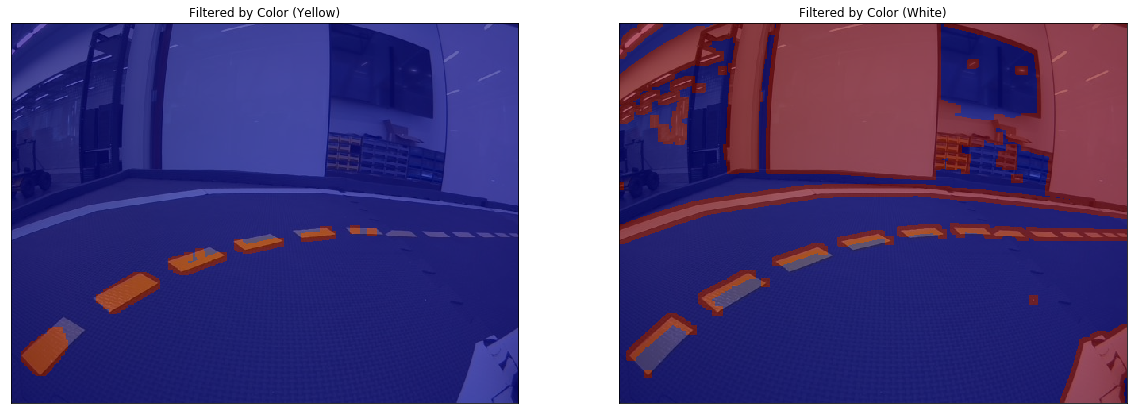

In [224]:
# TODO: Experiment with the size of the dilation kernel to see its effect on the masks
dilation_kernel = np.ones((11, 11), np.uint8)

mask_yellow = cv2.dilate(mask_yellow_orig, dilation_kernel, iterations=1)
mask_white = cv2.dilate(mask_white_orig, dilation_kernel, iterations=1)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imgrgb)
ax1.imshow(mask_yellow, cmap='jet', alpha=0.6)
ax1.set_title('Filtered by Color (Yellow)'), ax1.set_xticks([]), ax1.set_yticks([]);
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_white, cmap='jet', alpha=0.6)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);

## Masking

Let's now combine these masks to best isolate the features that we care about.

In [225]:
mask_left_edge = mask_ground * mask_yellow
mask_right_edge = mask_ground * mask_white

## Hough Transform

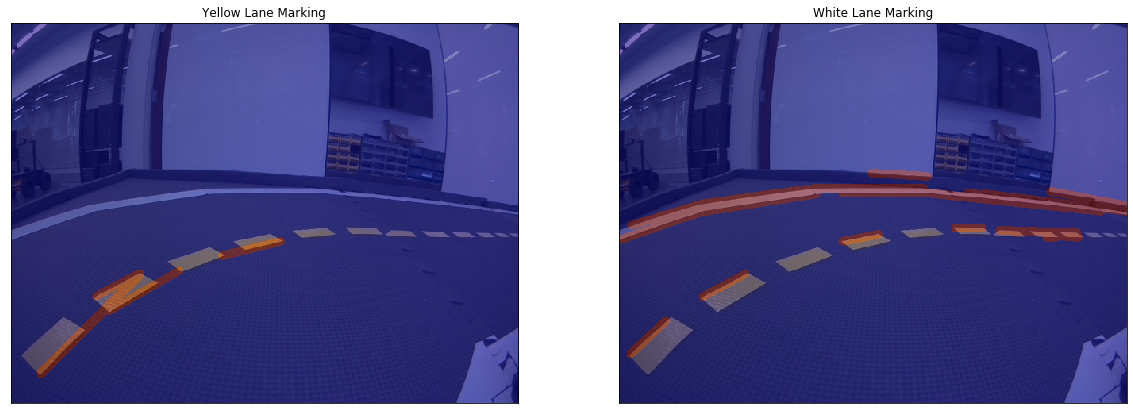

In [226]:
# Parameters for left line detection
hough_threshold_left = 50
hough_min_line_length_left = 10
hough_max_line_gap_left = 50
hough_rho_left = 1
hough_theta_left = 1*np.pi/180

# Parameters for white line detection
hough_threshold_right = 50 #100
hough_min_line_length_right = 2 #10
hough_max_line_gap_right = 15
hough_rho_right = 1
hough_theta_right = 1 * np.pi/180

lines_left = cv2.HoughLinesP(edges * mask_left_edge,
                        rho=hough_rho_left,
                        theta=hough_theta_left,
                        threshold=hough_threshold_left,
                        minLineLength=hough_min_line_length_left,
                        maxLineGap=hough_max_line_gap_left)




lines_right = cv2.HoughLinesP(edges * mask_right_edge,
                        rho=hough_rho_right,
                        theta=hough_theta_right,
                        threshold=hough_threshold_right,
                        minLineLength=hough_min_line_length_right,
                        maxLineGap=hough_max_line_gap_right)


lines_image_left = np.zeros_like(img)
if lines_left is not None:
    for line in lines_left:
        [[x1, y1, x2, y2]] = line
        cv2.line(lines_image_left, (x1, y1), (x2, y2), (255, 0, 0), 10)
        
lines_image_right = np.zeros_like(img)
if lines_right is not None:
    for line in lines_right:
        [[x1, y1, x2, y2]] = line
        cv2.line(lines_image_right, (x1, y1), (x2, y2), (255, 0, 0), 10)


# Visualize the resulting edges
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax1.imshow(lines_image_left, cmap='jet', alpha=0.5)
ax1.set_title('Yellow Lane Marking'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(lines_image_right, cmap='jet', alpha=0.5)
ax2.set_title('White Lane Marking'), ax2.set_xticks([]), ax2.set_yticks([]);

It will be useful to consider these line segments when expressed in the world (ground) reference frame. We can transform coordinates expressed in the image plane to the ground plane using the camera's homography estimate.

### Example: Image to Ground Projection

In this example, you are asked to implement a `project_image_to_ground` function that takes as input the homography matrix H and a point in the image, and outputs the corresponding coordinates in the world frame. We will then

In [227]:
def project_image_to_ground(H, x):
    """
        Args:
            H: The 3x3 image-to-ground plane homography (numpy.ndarray)
            x: An array of non-homogeneous image coordinates, one per column (numpy.ndarray)
        Returns:
            X: An array of non-homogeneous coordinates in the world (ground) frame, one per column (numpy.ndarray)
    """
    
    if x.shape[0] == 2:
        if x.ndim == 1:
            x = np.append(x, 1)
        else:
            x = np.vstack((x, np.ones((1, x.shape[1]))))
    
    X = H.dot(x)
    X = X/X[2,None]
    
    return X[0:2,]

The following code uses your `project_image_to_ground` function to render the line segments from the Hough transform. You can use this to validate your implementation. Remember, the origin of the ground frame is located at the mid-point of the Duckiebot's drive wheels (and on the ground, of course), with the $x$-axis pointing forward and the $y$-axis pointing to the left.

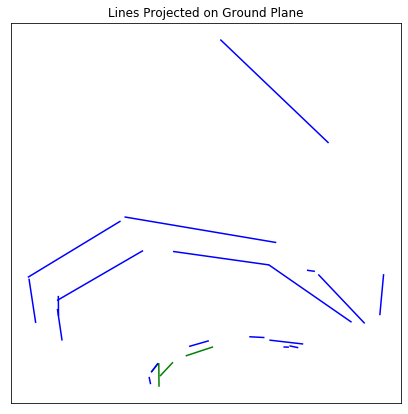

In [228]:
def render_ground_projections (lines_left, lines_right):
    """
        Renders the ground-plane projection of the left and right line detections
     
        Args:
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
    """

    fig = plt.figure(figsize = (7,7))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title('Lines Projected on Ground Plane'), ax1.set_xticks([]), ax1.set_yticks([]);
    if lines_left is not None:
        # Visualize the edges projected on to the ground plane
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            # The ground reference frame has positive X up and positivy Y left
            # So, for the sake of plotting we treat X as Y, and Y as -X
            ax1.plot(-Y, X, 'g-')

    if lines_right is not None:
        # Visualize the edges projeted on to the ground plane
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            # The ground reference frame has positive X up and positivy Y left
            # So, for the sake of plotting we treat X as Y, and Y as -X
            ax1.plot(-Y, X, 'b-')
            
render_ground_projections(lines_left, lines_right)

Having detected a candidate set of lines that correspond to the left (dashed-yellow) and right (solid-white) lane markings, we can now consider their orientation in the ground frame as an indication of the Duckiebot's orientation relative to its lane.

### Example: Line Orientations in the Ground Plane

In this example, you will explore the orientations of the detected lines in the ground frame. We provide the routines for computing the orientations of any detected line segments.

**Note**: The function below calls the `project_image_to_ground` function that you defined above. If you run into problems with your implementation of this function, consider looking at how it is implemented in the solutions.

In [184]:
def get_lane_marking_orientations(lines_left, lines_right):
    """
        Computes the orientation of any detected lines in the ground frame

        Args:
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
                         
        Returns:
            theta_left:  An n-element array of the orientations of each candidate line 
                         for the left lane markings
            theta_right  An n-element array of the orientations of each candidate line 
                         for the right lane markings
    """
    
    thetas_left = np.array([])
    thetas_right = np.array([])
    if lines_left is not None:
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)
            
            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_left = np.append(thetas_left, theta)

    if lines_right is not None:
        # Visualize the edges projeted on to the ground plane
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)

            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_right = np.append(thetas_right, theta)
            
    return (thetas_left, thetas_right)

(thetas_left, thetas_right) = get_lane_marking_orientations(lines_left, lines_right)

Depending on the number and nature of the line segments that you identified earlier using the Hough transform, there may be a lot of variance in the orientations. We can see this by looking at the histograms for the left and right orientations.

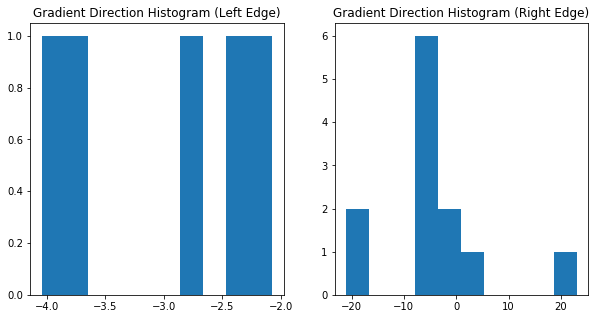

In [185]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(thetas_left*180/np.pi, bins=10)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(thetas_right*180/np.pi, bins=10)
ax2.set_title('Gradient Direction Histogram (Right Edge)');

If one of the histograms is too spread out and there isn't a clear or valid mode (i.e., there is no dominant peak or there is a dominant peak, but it corresponds to noise and is wrong), we will want to revisit the parameters that we used for the Hough transform to better isolate lines corresponding to the lane markings.

Depending on the number of bins that we used to generate the histogram, we also may see histograms that are peaked with a large number of lines having similar orientations. This can occur when there are other edges in the image that share the same orientation, namely the solid-white lane marking to the left.

## Estimating the Duckiebot's Lane-relative Orientation

Assuming that we have a valid set of line segments corresponding to the lane markings, we can use their orientations to estimate the Duckiebot's orientation relative to the lane. There are different ways that we can formulate this problem depending on the amount of outliers.

### Example: Using the Mode of the Distribution

One approach that we can adopt is to look at the mode of the distribution over the orientations of all the candidate line segments. This has the advantage that outliers don't affect the resulting estimate, unless, of course, they are the mode.

In [186]:
thetas = np.append(thetas_left, thetas_right)

# Determine the orientation of the left and right gradients as the mode of each histogram
(hist_thetas, bins_thetas) = np.histogram(thetas, bins=30)

idx = hist_thetas.argmax()
theta_argmax = (bins_thetas[idx] + bins_thetas[idx+1])/2

print('Mode: %.2f degrees' %(theta_argmax * 180/np.pi))

Mode: -5.63 degrees


### Example: Using the Mean of the Distribution

If the distribution over the orientations of the line segments is spread out, as might be the case for a curve, we can consider taking the mean of the set of orientations (including both the left and right candidate lane markings). A drawback of this approach is that any erroneous line segments will affect the resulting estimate.

In [187]:
thetas = np.append(thetas_left, thetas_right)

theta_mean = np.mean(thetas)

print("Mean: %.2f degrees" %(theta_mean * 180/np.pi))

Mean: -4.27 degrees


# 💻 🚙 Write the PID lane-following function

Now, we can consider combining the ability to estimate the orientation of the robot relative to its lane with a feedback controller that steers the vehicle (i.e., changes its angular rate) in order to maintain a desired orientation relative to the lane. In this case, an orientation of zero degrees. 

Here, we ask you to implement the following two functions:

1. A function that takes as input the image from the Duckiebot's forward-facing camera and outputs an estimate of the robot's orientation relative to the lane.

2. A PID controller that actuates the angular rate of the Duckiebot in order to maintain a dersired orientation relative to the lane.

## PID Heading Controller

We will use a PID controller to control the Duckiebot's heading relative to its lane.

⚠️ ***WARNING:***
- DO NOT CHANGE THE NAME OF THE FOLLOWING FUNCTION
- DO NOT CHANGE THE ARGUMENTS OF THE FUNCTION
- DO NOT CREATE NEW CODE CELLS, THEY WILL NOT BE CONSIDERED

In [5]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your PIDController function! 
# DO NOT CHANGE THE NAME OF THIS FUNCTION, INPUTS OR OUTPUTS, OR THINGS WILL BREAK

import numpy as np

# TODO: write your PID function for heading control!

def PIDController(v_0, theta_ref, theta_hat, prev_e, prev_int, delta_t):
    """
    Args:
        v_0 (:double:) linear Duckiebot speed (given).
        theta_ref (:double:) reference heading pose
        theta_hat (:double:) the current estiamted theta.
        prev_e (:double:) tracking error at previous iteration.
        prev_int (:double:) previous integral error term.
        delta_t (:double:) time interval since last call.
    returns:
        v_0 (:double:) linear velocity of the Duckiebot 
        omega (:double:) angular velocity of the Duckiebot
        e (:double:) current tracking error (automatically becomes prev_e_y at next iteration).
        e_int (:double:) current integral error (automatically becomes prev_int_y at next iteration).
    """
    
    # TODO: these are random values, you have to implement your own PID controller in here
    omega = np.random.uniform(-8.0, 8.0)
    e = np.random.random()
    e_int = np.random.random()
    
    # SOLUTION
    # Tracking error
    e = theta_ref - theta_hat

    # integral of the error
    e_int = prev_int + e*delta_t

    # anti-windup - preventing the integral error from growing too much
    e_int = max(min(e_int,2),-2)

    # derivative of the error
    e_der = (e - prev_e)/delta_t

    # controller coefficients
    Kp = 5
    Ki = 0.2
    Kd = 0.1

    # PID controller for omega
    omega = Kp*e + Ki*e_int + Kd*e_der
    
    #print(f"\n\nDelta time : {delta_t} \nE : {np.rad2deg(e)} \nE int : {e_int} \nPrev e : {prev_e} \nU : {u} \nTheta hat: {np.rad2deg(theta_hat)} \n")
        
    return [v_0, omega], e, e_int

## Estimating the Robot's Lane-relative Orientation  

Based on what we have learned above, write a function that takes as input the image from the Duckiebot's camera (in the BGR color space) and outputs an estimate of the robot's orienatation relative to the lane, along with the left and right line segments from the Hough Transform. The orientation will serve as the estimate of the robot's lane-relative heading that is used by the PID controller.

You are welcome to add additional functions in the cell below that you want to call from your `estimate_lane_relative_headings` function (e.g., the `project_image_to_ground` function that you created above, or the `get_lane_marking_orientations`.

⚠️ ***WARNING:***
- DO NOT CHANGE THE NAME OF THE FOLLOWING FUNCTION
- DO NOT CHANGE THE ARGUMENTS OF THE FUNCTION
- DO NOT CREATE NEW CODE CELLS, THEY WILL NOT BE CONSIDERED

In [217]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your DeltaPhi function! 
# DO NOT CHANGE THE NAME OF THIS FUNCTION, INPUTS OR OUTPUTS, OR THINGS WILL BREAK

import numpy as np
import cv2

#TODO: write a correct function

def estimate_lane_relative_heading(image):
    """
        Args:
            image: An image from the robot's camera in the BGR color space (numpy.ndarray)
        Return:
            theta_hat: An estimate of the robot's heading (radians) relative to the lane (float)
            lines_left:  An n x 4 array of candidate lines for the right lane markings (numpy.ndarray)
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings (numpy.ndarray)
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
    """
    
    # TODO: these are random values, you have to implement your own solution in here
    theta_hat = np.random.random()
    lines_left = np.array([])
    lines_right = np.array([])
    
    # SOLUTION
    
    # The image-to-ground homography associated with this image (Jacopo's)
    H = np.array([-4.137917960301845e-05, -0.00011445854191468058, -0.1595567007347241, 
                  0.0008382870319844166, -4.141689222457687e-05, -0.2518201638170328, 
                  -0.00023561657746150284, -0.005370140574116084, 0.9999999999999999])

    H = np.reshape(H,(3, 3))
    Hinv = np.linalg.inv(H)
    
    # Masking the horizon
    xmax = 2
    X = np.array([xmax, 0.0, 1.0])
    x = Hinv.dot(X)
    x = x/x[-1]

    height = image.shape[1]
    mask_ground = np.ones(img.shape, dtype=np.uint8)
    mask_ground[0:int(np.floor(x[1])),:] = 0
    
    
    # Gaussian smoothing
    sigma = 2
    img_gaussian_filter = cv2.GaussianBlur(image,(0,0), sigma)

    # Canny edge detection
    canny_lower_threshold = 80
    canny_upper_threshold = 200
    canny_kernel_size = 3;

    edges = cv2.Canny(img_gaussian_filter, canny_lower_threshold, canny_upper_threshold, canny_kernel_size)

    
    # Color-based masking
    # Using the above tool, we can identify the bounds as follows
    # Since OpenCV uses a Hue range of [0, 179], we need to divide the Hue values above by 2
    white_lower_hsv = np.array([0/2, 3*255/100, 52*255/100])
    white_upper_hsv = np.array([360/2, 26*255/100, 96*255/100])
    yellow_lower_hsv = np.array([44/2, 47*255/100, 48*255/100])
    yellow_upper_hsv = np.array([55/2, 100*255/100, 85*255/100])

    mask_white_orig = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow_orig = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    # Color dilation
    dilation_kernel = np.ones((11, 11), np.uint8)

    mask_yellow = cv2.dilate(mask_yellow_orig, dilation_kernel, iterations=1)
    mask_white = cv2.dilate(mask_white_orig, dilation_kernel, iterations=1)
    
    # Masking
    mask_left_edge = mask_ground * mask_yellow
    mask_right_edge = mask_ground * mask_white
  
    # Hough Transform
    # Parameters for left line detection
    hough_threshold_left = 50
    hough_min_line_length_left = 10
    hough_max_line_gap_left = 50
    hough_rho_left = 1
    hough_theta_left = 1*np.pi/180

    # Parameters for white line detection
    hough_threshold_right = 50 #100
    hough_min_line_length_right = 2 #10
    hough_max_line_gap_right = 15
    hough_rho_right = 1
    hough_theta_right = 1 * np.pi/180

    lines_left = cv2.HoughLinesP(edges * mask_left_edge,
                            rho=hough_rho_left,
                            theta=hough_theta_left,
                            threshold=hough_threshold_left,
                            minLineLength=hough_min_line_length_left,
                            maxLineGap=hough_max_line_gap_left)




    lines_right = cv2.HoughLinesP(edges * mask_right_edge,
                            rho=hough_rho_right,
                            theta=hough_theta_right,
                            threshold=hough_threshold_right,
                            minLineLength=hough_min_line_length_right,
                            maxLineGap=hough_max_line_gap_right)


    (thetas_left, thetas_right) = get_lane_marking_orientations(lines_left, lines_right)
    thetas = np.append(thetas_left, thetas_right)

    # Determine the orientation of the left and right gradients as the mode of each histogram
    (hist_thetas, bins_thetas) = np.histogram(thetas, bins=30)

    idx = hist_thetas.argmax()
    theta_argmax = (bins_thetas[idx] + bins_thetas[idx+1])/2
    theta_mean = np.mean(thetas)

    theta_hat = theta_argmax

    return (theta_hat, lines_left, lines_right)



def project_image_to_ground(H, x):
    """
        Args:
            H: The 3x3 image-to-ground plane homography (numpy.ndarray)
            x: An array of non-homogeneous image coordinates, one per column (numpy.ndarray)
        Returns:
            X: An array of non-homogeneous coordinates in the world (ground) frame, one per column (numpy.ndarray)
    """
    
    if x.shape[0] == 2:
        if x.ndim == 1:
            x = np.append(x, 1)
        else:
            x = np.vstack((x, np.ones((1, x.shape[1]))))
    
    X = H.dot(x)
    X = X/X[2,None]
    
    return X[0:2,]



def get_lane_marking_orientations(lines_left, lines_right):
    """
        Computes the orientation of any detected lines in the ground frame

        Args:
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
                         
        Returns:
            theta_left:  An n-element array of the orientations of each candidate line 
                         for the left lane markings
            theta_right  An n-element array of the orientations of each candidate line 
                         for the right lane markings
    """
    
    thetas_left = np.array([])
    thetas_right = np.array([])
    if lines_left is not None:
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)
            
            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_left = np.append(thetas_left, theta)

    if lines_right is not None:
        # Visualize the edges projeted on to the ground plane
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)

            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_right = np.append(thetas_right, theta)
            
    return (thetas_left, thetas_right)

### Test the `estimate_lane_relative_heading` function

As we have seen, unit tests are valuable in confirming that a particular piece of code works as intended when provided with an expected input.

Let's see if the function you wrote above passes the following test!

First Image: theta_hat: -4.97 degrees
Second Image: theta_hat: 32.94 degrees


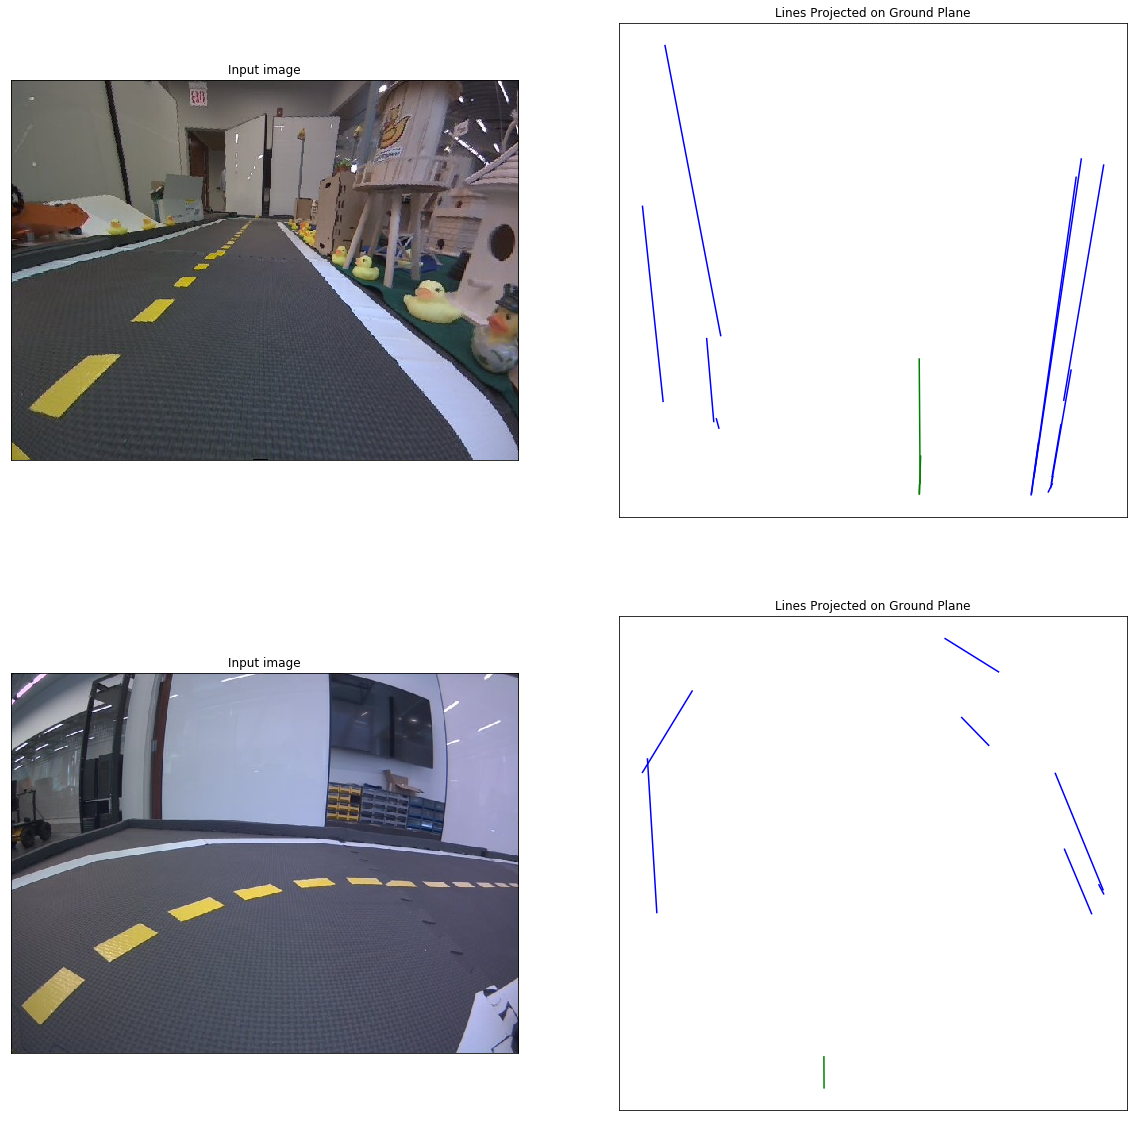

In [219]:
import sys
sys.path.append('../')
from unit_test import UnitTestELRH

# This function has hardcoded values (bad practice!) to test the LMOrientation function above. 
# The test will be successful if you get angles around 220 degrees (left edge) and 320 degrees (right edge)

UnitTestELRH(estimate_lane_relative_heading)